In [1]:
#https://developers.google.com/earth-engine/api_docs#eefeatureget
import ee
import datetime
import IPython.display
from IPython.display import Image
import bqplot
import ipywidgets
import pprint
pp = pprint.PrettyPrinter(indent=2) # for printing pretty idk what it is... print with pp.pprint(print stuff)
import pandas as pd
import geopandas as gpd
import matplotlib.dates as mdates
from matplotlib import dates
%matplotlib inline
from shapely.geometry import shape
import skimage
import traitlets
import dateutil.parser
import numpy as np
import ipyleaflet
from ipyleaflet import (LayersControl, basemaps, basemap_to_tiles, LayerGroup)

def GetTileLayerUrl(ee_image_object):
    map_id = ee.Image(ee_image_object).getMapId()
    tile_url_template = "https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}"
    return tile_url_template.format(**map_id)


# Initialize
ee.Initialize()

#To-Do


In [72]:
# Dates
startTime = datetime.datetime(2013,1,1)
endTime = datetime.datetime(2019,5,1)

# AOI
ried = ee.FeatureCollection('users/tillmueller1990/ried_roi')
germany = ee.Collection.loadTable('USDOS/LSIB_SIMPLE/2017').filterMetadata('country_co','equals','GM')
germany_1 = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017').filter(ee.Filter.eq('country_na','Germany'))

# Create an empty image into which to paint the features, cast to byte.
empty = ee.Image().byte();

# Paint all the polygon edges with the same number and width, display.
germany_outline = empty.paint(germany, 1, 3)

#Sample Points Germany 500
random_points = ee.FeatureCollection.randomPoints(clc.geometry(), 5000)


## Precipitaion Data (Radolan DWD)

In [41]:
#Load Radolan from Assest 
radolan = ee.ImageCollection('users/tillmueller1990/radolan/r_2009-2019')

#Load GSMAP Hourly Precipitation
gsmap = ee.ImageCollection('JAXA/GPM_L3/GSMaP/v6/operational').select(['hourlyPrecipRate']).filterDate('2015-01-01', '2016-01-01')

#CHIRPS 5km daily precipitation 
chirps  = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY')
chirps_precipitation = chirps.select('precipitation')

## Soil Moisture

In [4]:
#Soil Moisture Datasets

#NASA-USDA Global Soil Moisture Data / 3 days / 2010- 2019 / 0.25 arc degrees / SMOS lvl2 integrated into two-layer palmer model
SMOS = ee.ImageCollection('NASA_USDA/HSL/soil_moisture')
surface_moisture = SMOS.select('ssm') #units mm, min=0 max=25
subsurface_moisture = SMOS.select('susm') #units: mm min=0, max=275
moisture_profile = SMOS.select('smp') #units: fraction, min0, max 1

#NASA-USDA SMAP Global Soil Moisture Data / 3 days / 2015 - 2019 / 0.25 arc degrees / SMAP level 3 + two-layer Palmer
SMAP = ee.ImageCollection('NASA_USDA/HSL/SMAP_soil_moisture')

#GLDAS-2.1: Global Land Data Assimilation System / 3 hours / 0.25 arc degrees / 2000 - 2019 / 

#Datasets

## Corine Land Cover 

In [5]:
# Load last corine land cover image 
clc = ee.Image.load('COPERNICUS/CORINE/V18_5_1/100m/2012', -1)

# Mask areas where soil moisture measurements valid (farmland cat.:11-17)
clc_mask = clc.gte(11)and(clc.lte(17)) #binary map for updateMask
clc = clc.updateMask(clc_mask) #set mask for not Farmland

# Clip to extend of germany
clc = clc.clip(germany_1) 

# Feature Collection of clc farmland cat.: 11-17 with 350m resolution
clc_vector = clc.reduceToVectors(geometry=germany_1, crs=clc.projection(), scale=350, geometryType='polygon', eightConnected = False)
#Limit to first 5000 Features 
clc_vector = clc_vector.limit(5000)

## Iterate over ImageCollection returning pandas dataframe 

In [9]:
#Geometrys, Regions
points = ee.FeatureCollection([
            ee.Feature(ee.Geometry.Point(8.234870250943459,49.80831604635797)),
            ee.Feature(ee.Geometry.Point(8.241221721890724,49.6585087644599)),
            ])
point = ee.Feature(ee.Geometry.Point(8.234870250943459,49.80831604635797))

#Time
start,end = datetime.datetime(2015,1,1),datetime.datetime(2016,1,1)
#Source Dataset
sm = surface_moisture.filterDate(start,end)

# Function Convert a FeatureCollection into a pandas DataFrame; Features is a list of dict with the output
def fc2df(fc):
    # Convert a FeatureCollection into a pandas DataFrame
    # Features is a list of dict with the output
    features = fc.getInfo()['features']

    dictarr = []
    n=0
    b=0
    for f in features:
        n = n+1
        print("n",n)
        # Store all attributes in a dict
        attr = f['properties']
        # and treat geometry separately
        attr['geometry'] = f['geometry']  # GeoJSON Feature!
        #attr['geometrytype'] = f['geometry']['type']
        dictarr.append(attr)

    df = gpd.GeoDataFrame(dictarr)
    # Convert GeoJSON features to shape
    #WAS GENAU PASSIER HIER map lambda???
    #df['geometry'] = map(lambda x: shape(x), df.geometry)    
    #df['geometry'] = map(lambda s: shape(s), df['geometry'])
    print("map", df['geometry'])
    b=b+1
    print("lambda",b)
    #pp.pprint(df.geometry)
    print("loop 2 ende")
    return df

# Function to iterate over image collection, returning a pandas dataframe
def extract_point_values(img_id, pts):
    image = ee.Image(img_id)
    #Ad reducer output to the Features in the collection.
    fc_image_red = image.reduceRegions(collection=pts, reducer=ee.Reducer.mean(), scale=1000)
    # Convert to Pandas Dataframe
    df_image_red = fc2df(fc_image_red)
    # Add Date as Variable
    df_image_red['date'] = datetime.datetime.strptime(image.getInfo()['properties']['ID'][23:29],'%y%m%d')
    return df_image_red

#List of image propertys 
sm_prop = surface_moisture.first().propertyNames().getInfo()
print('Check 1')
#Get propertie from every image to a List
sm_id = [] #empty list
for f in sm.getInfo()['features']: 
    image_id = str('NASA_USDA/HSL/soil_moisture/') + f['properties']['ID']#.encode('ascii', 'ignore')
    sm_id.append(image_id)
print("check 2")
#### Create Initial Pandas Dataframe
df_all = extract_point_values(sm_id[0], points)
df_all = df_all.drop([0,1])
print("check 3")
#### Iterate over all impages
c=0
for i in sm_id:
    c = c+ 1
    print("c",c)
    df_all = df_all.append(extract_point_values(i, points))
print("check 4")
    
sm_point1 = df_all.loc[0]
sm_point2 = df_all.loc[1]


#Get Pixel for points maybe polygons? Value must be a regional reducer over polygon ; 


Check 1
check 2
n 1
n 2
map 0    {'type': 'Point', 'coordinates': [8.2348702509...
1    {'type': 'Point', 'coordinates': [8.2412217218...
Name: geometry, dtype: object
lambda 1
loop 2 ende
check 3
c 1
n 1
n 2
map 0    {'type': 'Point', 'coordinates': [8.2348702509...
1    {'type': 'Point', 'coordinates': [8.2412217218...
Name: geometry, dtype: object
lambda 1
loop 2 ende
c 2
n 1
n 2
map 0    {'type': 'Point', 'coordinates': [8.2348702509...
1    {'type': 'Point', 'coordinates': [8.2412217218...
Name: geometry, dtype: object
lambda 1
loop 2 ende
c 3
n 1
n 2
map 0    {'type': 'Point', 'coordinates': [8.2348702509...
1    {'type': 'Point', 'coordinates': [8.2412217218...
Name: geometry, dtype: object
lambda 1
loop 2 ende
c 4
n 1
n 2
map 0    {'type': 'Point', 'coordinates': [8.2348702509...
1    {'type': 'Point', 'coordinates': [8.2412217218...
Name: geometry, dtype: object
lambda 1
loop 2 ende
c 5
n 1
n 2
map 0    {'type': 'Point', 'coordinates': [8.2348702509...
1    {'type': 'Point', '

c 46
n 1
n 2
map 0    {'type': 'Point', 'coordinates': [8.2348702509...
1    {'type': 'Point', 'coordinates': [8.2412217218...
Name: geometry, dtype: object
lambda 1
loop 2 ende
c 47
n 1
n 2
map 0    {'type': 'Point', 'coordinates': [8.2348702509...
1    {'type': 'Point', 'coordinates': [8.2412217218...
Name: geometry, dtype: object
lambda 1
loop 2 ende
c 48
n 1
n 2
map 0    {'type': 'Point', 'coordinates': [8.2348702509...
1    {'type': 'Point', 'coordinates': [8.2412217218...
Name: geometry, dtype: object
lambda 1
loop 2 ende
c 49
n 1
n 2
map 0    {'type': 'Point', 'coordinates': [8.2348702509...
1    {'type': 'Point', 'coordinates': [8.2412217218...
Name: geometry, dtype: object
lambda 1
loop 2 ende
c 50
n 1
n 2
map 0    {'type': 'Point', 'coordinates': [8.2348702509...
1    {'type': 'Point', 'coordinates': [8.2412217218...
Name: geometry, dtype: object
lambda 1
loop 2 ende
c 51
n 1
n 2
map 0    {'type': 'Point', 'coordinates': [8.2348702509...
1    {'type': 'Point', 'coordinates': 

n 1
n 2
map 0    {'type': 'Point', 'coordinates': [8.2348702509...
1    {'type': 'Point', 'coordinates': [8.2412217218...
Name: geometry, dtype: object
lambda 1
loop 2 ende
c 93
n 1
n 2
map 0    {'type': 'Point', 'coordinates': [8.2348702509...
1    {'type': 'Point', 'coordinates': [8.2412217218...
Name: geometry, dtype: object
lambda 1
loop 2 ende
c 94
n 1
n 2
map 0    {'type': 'Point', 'coordinates': [8.2348702509...
1    {'type': 'Point', 'coordinates': [8.2412217218...
Name: geometry, dtype: object
lambda 1
loop 2 ende
c 95
n 1
n 2
map 0    {'type': 'Point', 'coordinates': [8.2348702509...
1    {'type': 'Point', 'coordinates': [8.2412217218...
Name: geometry, dtype: object
lambda 1
loop 2 ende
c 96
n 1
n 2
map 0    {'type': 'Point', 'coordinates': [8.2348702509...
1    {'type': 'Point', 'coordinates': [8.2412217218...
Name: geometry, dtype: object
lambda 1
loop 2 ende
c 97
n 1
n 2
map 0    {'type': 'Point', 'coordinates': [8.2348702509...
1    {'type': 'Point', 'coordinates': [8.24

In [45]:
#Geometrys, Regions
points = ee.FeatureCollection([
            ee.Feature(ee.Geometry.Point(8.234870250943459,49.80831604635797)),
            ee.Feature(ee.Geometry.Point(8.241221721890724,49.6585087644599)),
            ])
point = ee.Feature(ee.Geometry.Point(8.234870250943459,49.80831604635797))

#Time
start,end = datetime.datetime(2015,1,1),datetime.datetime(2016,1,1)
#Source Dataset
chirps = chirps_precipitation.filterDate(start,end)
# Function Convert a FeatureCollection into a pandas DataFrame; Features is a list of dict with the output
def fc2df(fc):
    # Convert a FeatureCollection into a pandas DataFrame
    # Features is a list of dict with the output
    features = fc.getInfo()['features']

    dictarr = []
    for f in features:
        # Store all attributes in a dict
        attr = f['properties']
        # and treat geometry separately
        attr['geometry'] = f['geometry']  # GeoJSON Feature!
        #attr['geometrytype'] = f['geometry']['type']
        dictarr.append(attr)

    df = gpd.GeoDataFrame(dictarr)
    # Convert GeoJSON features to shape
    #df['geometry'] = map(lambda x: shape(x), df.geometry)    
    return df

# Function to iterate over image collection, returning a pandas dataframe
def extract_point_values(img_id, pts):
    image = ee.Image(img_id)
    #Ad reducer output to the Features in the collection.
    fc_image_red = image.reduceRegions(collection=pts, reducer=ee.Reducer.mean(), scale=1000)
    # Convert to Pandas Dataframe
    df_image_red = fc2df(fc_image_red)
    # Add Date as Variable
    df_image_red['date'] = datetime.datetime.strptime(image.getInfo()['id'][22:31],'%Y%m%d')
    print(df_image_red)
    return df_image_red

#List of image propertys 
chirps_prop = surface_moisture.first().propertyNames().getInfo()
print('Check 1')
#Get propertie from every image to a List
chirps_id = [] #empty list
chirps_id = [item.get('id') for item in chirps.getInfo().get('features')]
#### Create Initial Pandas Dataframe
df_all = extract_point_values(chirps_id[0], points)
df_all = df_all.drop([0,1])
print("check 3")
#### Iterate over all impages
c=0
for i in chirps_id:
    c = c+ 1
    print("c",c)
    df_all = df_all.append(extract_point_values(i, points))
print("check 4")
#### Display Results
pp.pprint(df_all)
rad_point1 = df_all.loc[0]
rad_point2 = df_all.loc[1]


Check 1
   mean                                           geometry       date
0   0.0  {'type': 'Point', 'coordinates': [8.2348702509... 2015-01-01
1   0.0  {'type': 'Point', 'coordinates': [8.2412217218... 2015-01-01
check 3
c 1
   mean                                           geometry       date
0   0.0  {'type': 'Point', 'coordinates': [8.2348702509... 2015-01-01
1   0.0  {'type': 'Point', 'coordinates': [8.2412217218... 2015-01-01
c 2
   mean                                           geometry       date
0   0.0  {'type': 'Point', 'coordinates': [8.2348702509... 2015-01-02
1   0.0  {'type': 'Point', 'coordinates': [8.2412217218... 2015-01-02
c 3
        mean                                           geometry       date
0  10.778063  {'type': 'Point', 'coordinates': [8.2348702509... 2015-01-03
1  12.553872  {'type': 'Point', 'coordinates': [8.2412217218... 2015-01-03
c 4
   mean                                           geometry       date
0   0.0  {'type': 'Point', 'coordinates': [

   mean                                           geometry       date
0   0.0  {'type': 'Point', 'coordinates': [8.2348702509... 2015-02-07
1   0.0  {'type': 'Point', 'coordinates': [8.2412217218... 2015-02-07
c 39
   mean                                           geometry       date
0   0.0  {'type': 'Point', 'coordinates': [8.2348702509... 2015-02-08
1   0.0  {'type': 'Point', 'coordinates': [8.2412217218... 2015-02-08
c 40
   mean                                           geometry       date
0   0.0  {'type': 'Point', 'coordinates': [8.2348702509... 2015-02-09
1   0.0  {'type': 'Point', 'coordinates': [8.2412217218... 2015-02-09
c 41
   mean                                           geometry       date
0   0.0  {'type': 'Point', 'coordinates': [8.2348702509... 2015-02-10
1   0.0  {'type': 'Point', 'coordinates': [8.2412217218... 2015-02-10
c 42
   mean                                           geometry       date
0   0.0  {'type': 'Point', 'coordinates': [8.2348702509... 2015-02-11


   mean                                           geometry       date
0   0.0  {'type': 'Point', 'coordinates': [8.2348702509... 2015-03-17
1   0.0  {'type': 'Point', 'coordinates': [8.2412217218... 2015-03-17
c 77
   mean                                           geometry       date
0   0.0  {'type': 'Point', 'coordinates': [8.2348702509... 2015-03-18
1   0.0  {'type': 'Point', 'coordinates': [8.2412217218... 2015-03-18
c 78
   mean                                           geometry       date
0   0.0  {'type': 'Point', 'coordinates': [8.2348702509... 2015-03-19
1   0.0  {'type': 'Point', 'coordinates': [8.2412217218... 2015-03-19
c 79
   mean                                           geometry       date
0   0.0  {'type': 'Point', 'coordinates': [8.2348702509... 2015-03-20
1   0.0  {'type': 'Point', 'coordinates': [8.2412217218... 2015-03-20
c 80
   mean                                           geometry       date
0   0.0  {'type': 'Point', 'coordinates': [8.2348702509... 2015-03-21


   mean                                           geometry       date
0   0.0  {'type': 'Point', 'coordinates': [8.2348702509... 2015-04-24
1   0.0  {'type': 'Point', 'coordinates': [8.2412217218... 2015-04-24
c 115
   mean                                           geometry       date
0   0.0  {'type': 'Point', 'coordinates': [8.2348702509... 2015-04-25
1   0.0  {'type': 'Point', 'coordinates': [8.2412217218... 2015-04-25
c 116
   mean                                           geometry       date
0   0.0  {'type': 'Point', 'coordinates': [8.2348702509... 2015-04-26
1   0.0  {'type': 'Point', 'coordinates': [8.2412217218... 2015-04-26
c 117
   mean                                           geometry       date
0   0.0  {'type': 'Point', 'coordinates': [8.2348702509... 2015-04-27
1   0.0  {'type': 'Point', 'coordinates': [8.2412217218... 2015-04-27
c 118
   mean                                           geometry       date
0   0.0  {'type': 'Point', 'coordinates': [8.2348702509... 2015-04

   mean                                           geometry       date
0   0.0  {'type': 'Point', 'coordinates': [8.2348702509... 2015-06-01
1   0.0  {'type': 'Point', 'coordinates': [8.2412217218... 2015-06-01
c 153
   mean                                           geometry       date
0   0.0  {'type': 'Point', 'coordinates': [8.2348702509... 2015-06-02
1   0.0  {'type': 'Point', 'coordinates': [8.2412217218... 2015-06-02
c 154
   mean                                           geometry       date
0   0.0  {'type': 'Point', 'coordinates': [8.2348702509... 2015-06-03
1   0.0  {'type': 'Point', 'coordinates': [8.2412217218... 2015-06-03
c 155
   mean                                           geometry       date
0   0.0  {'type': 'Point', 'coordinates': [8.2348702509... 2015-06-04
1   0.0  {'type': 'Point', 'coordinates': [8.2412217218... 2015-06-04
c 156
   mean                                           geometry       date
0   0.0  {'type': 'Point', 'coordinates': [8.2348702509... 2015-06

   mean                                           geometry       date
0   0.0  {'type': 'Point', 'coordinates': [8.2348702509... 2015-07-09
1   0.0  {'type': 'Point', 'coordinates': [8.2412217218... 2015-07-09
c 191
   mean                                           geometry       date
0   0.0  {'type': 'Point', 'coordinates': [8.2348702509... 2015-07-10
1   0.0  {'type': 'Point', 'coordinates': [8.2412217218... 2015-07-10
c 192
   mean                                           geometry       date
0   0.0  {'type': 'Point', 'coordinates': [8.2348702509... 2015-07-11
1   0.0  {'type': 'Point', 'coordinates': [8.2412217218... 2015-07-11
c 193
   mean                                           geometry       date
0   0.0  {'type': 'Point', 'coordinates': [8.2348702509... 2015-07-12
1   0.0  {'type': 'Point', 'coordinates': [8.2412217218... 2015-07-12
c 194
   mean                                           geometry       date
0   0.0  {'type': 'Point', 'coordinates': [8.2348702509... 2015-07

   mean                                           geometry       date
0   0.0  {'type': 'Point', 'coordinates': [8.2348702509... 2015-08-16
1   0.0  {'type': 'Point', 'coordinates': [8.2412217218... 2015-08-16
c 229
   mean                                           geometry       date
0   0.0  {'type': 'Point', 'coordinates': [8.2348702509... 2015-08-17
1   0.0  {'type': 'Point', 'coordinates': [8.2412217218... 2015-08-17
c 230
   mean                                           geometry       date
0   0.0  {'type': 'Point', 'coordinates': [8.2348702509... 2015-08-18
1   0.0  {'type': 'Point', 'coordinates': [8.2412217218... 2015-08-18
c 231
   mean                                           geometry       date
0   0.0  {'type': 'Point', 'coordinates': [8.2348702509... 2015-08-19
1   0.0  {'type': 'Point', 'coordinates': [8.2412217218... 2015-08-19
c 232
   mean                                           geometry       date
0   0.0  {'type': 'Point', 'coordinates': [8.2348702509... 2015-08

   mean                                           geometry       date
0   0.0  {'type': 'Point', 'coordinates': [8.2348702509... 2015-09-23
1   0.0  {'type': 'Point', 'coordinates': [8.2412217218... 2015-09-23
c 267
   mean                                           geometry       date
0   0.0  {'type': 'Point', 'coordinates': [8.2348702509... 2015-09-24
1   0.0  {'type': 'Point', 'coordinates': [8.2412217218... 2015-09-24
c 268
   mean                                           geometry       date
0   0.0  {'type': 'Point', 'coordinates': [8.2348702509... 2015-09-25
1   0.0  {'type': 'Point', 'coordinates': [8.2412217218... 2015-09-25
c 269
   mean                                           geometry       date
0   0.0  {'type': 'Point', 'coordinates': [8.2348702509... 2015-09-26
1   0.0  {'type': 'Point', 'coordinates': [8.2412217218... 2015-09-26
c 270
   mean                                           geometry       date
0   0.0  {'type': 'Point', 'coordinates': [8.2348702509... 2015-09

   mean                                           geometry       date
0   0.0  {'type': 'Point', 'coordinates': [8.2348702509... 2015-10-31
1   0.0  {'type': 'Point', 'coordinates': [8.2412217218... 2015-10-31
c 305
   mean                                           geometry       date
0   0.0  {'type': 'Point', 'coordinates': [8.2348702509... 2015-11-01
1   0.0  {'type': 'Point', 'coordinates': [8.2412217218... 2015-11-01
c 306
   mean                                           geometry       date
0   0.0  {'type': 'Point', 'coordinates': [8.2348702509... 2015-11-02
1   0.0  {'type': 'Point', 'coordinates': [8.2412217218... 2015-11-02
c 307
       mean                                           geometry       date
0  3.723815  {'type': 'Point', 'coordinates': [8.2348702509... 2015-11-03
1  3.055305  {'type': 'Point', 'coordinates': [8.2412217218... 2015-11-03
c 308
   mean                                           geometry       date
0   0.0  {'type': 'Point', 'coordinates': [8.234870250

   mean                                           geometry       date
0   0.0  {'type': 'Point', 'coordinates': [8.2348702509... 2015-12-08
1   0.0  {'type': 'Point', 'coordinates': [8.2412217218... 2015-12-08
c 343
   mean                                           geometry       date
0   0.0  {'type': 'Point', 'coordinates': [8.2348702509... 2015-12-09
1   0.0  {'type': 'Point', 'coordinates': [8.2412217218... 2015-12-09
c 344
   mean                                           geometry       date
0   0.0  {'type': 'Point', 'coordinates': [8.2348702509... 2015-12-10
1   0.0  {'type': 'Point', 'coordinates': [8.2412217218... 2015-12-10
c 345
        mean                                           geometry       date
0   8.327037  {'type': 'Point', 'coordinates': [8.2348702509... 2015-12-11
1  10.304196  {'type': 'Point', 'coordinates': [8.2412217218... 2015-12-11
c 346
   mean                                           geometry       date
0   0.0  {'type': 'Point', 'coordinates': [8.234870

0   2015-01-04
0   2015-01-07
0   2015-01-10
0   2015-01-13
0   2015-01-16
       ...    
0   2015-12-21
0   2015-12-24
0   2015-12-27
0   2015-12-30
0   2016-01-02
Name: date, Length: 122, dtype: datetime64[ns]


/home/elisabeth/miniconda3/envs/wradlib/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


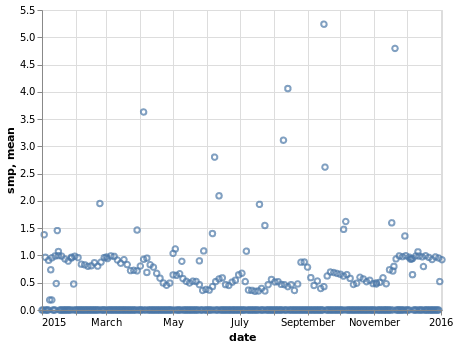

In [61]:
import altair as alt
alt.renderers.enable('notebook')
pp.pprint(sm_point1['date'])
rad_point1['mean'] = rad_point1['mean'].multiply(4)
chart_sm = alt.Chart(sm_point1).mark_point().encode(x='date', y= 'smp')
chart_pp = alt.Chart(rad_point1).mark_point().encode(x='date', y='mean')
#alt.vconcat(chart_sm, chart_pp)
chart_sm + chart_pp

In [40]:
pp.pprint(rad_point1)
pp.pprint(sm_point1)

         mean                                           geometry       date
0    0.000000  {'type': 'Point', 'coordinates': [8.2348702509... 2015-01-01
0    0.000000  {'type': 'Point', 'coordinates': [8.2348702509... 2015-01-02
0   10.778063  {'type': 'Point', 'coordinates': [8.2348702509... 2015-01-03
0    0.000000  {'type': 'Point', 'coordinates': [8.2348702509... 2015-01-04
0    0.000000  {'type': 'Point', 'coordinates': [8.2348702509... 2015-01-05
..        ...                                                ...        ...
0    0.000000  {'type': 'Point', 'coordinates': [8.2348702509... 2015-12-27
0    0.000000  {'type': 'Point', 'coordinates': [8.2348702509... 2015-12-28
0    0.000000  {'type': 'Point', 'coordinates': [8.2348702509... 2015-12-29
0    0.000000  {'type': 'Point', 'coordinates': [8.2348702509... 2015-12-30
0    4.069681  {'type': 'Point', 'coordinates': [8.2348702509... 2015-12-31

[365 rows x 3 columns]
         smp        ssm      ssma        susm     susma  \
0   0

In [ ]:
import altair as alt
data = 
chart = alt.Chart(data)

## Soil Moisture from Sentinel 1

In [ ]:
#Derived from Sentinel 1 A/B 2014-10 - Present
s1 = ee.ImageCollection('COPERNICUS/S1_GRD')


## Viewer

In [73]:
#Visualization Parameters
dark_matter_layer = basemap_to_tiles(basemaps.CartoDB.DarkMatter)
germany_viz = GetTileLayerUrl(germany_outline.visualize())
#radolan_viz = GetTileLayerUrl(radolan.visualize(min=0,max=40,bands=['b1']))
clc_viz = GetTileLayerUrl(clc.visualize(min=0,max=7,palette=['FFE6FF','FFFFA8','FFFF00','E6E600','E68000','F2A64D','E6A600']))
clc_vector_viz = GetTileLayerUrl(clc_vector.draw(color='red').visualize())
#surface_moisture_viz = GetTileLayerUrl(surface_moisture.visualize(min=0,max=28,palette=['0300ff', '418504', 'efff07', 'efff07', 'ff0303']))
random_points_viz = GetTileLayerUrl(random_points.draw(color='blue').visualize())

# Create layer group
layer_group = LayerGroup(layers=(ipyleaflet.TileLayer(url=clc_viz,name='Corine Land Cover 2012'), 
                                 ipyleaflet.TileLayer(url=germany_viz, name='german boundary'), 
                                 ipyleaflet.TileLayer(url=clc_vector_viz, name='clc_vector'),
                                 ipyleaflet.TileLayer(url=random_points_viz, name='rand point')
                                 #ipyleaflet.TileLayer(url=surface_moisture_viz, name='GSMD surface moisture')
                                ))

#Map options
center,zoom = [12.727661, 51.229822],4

#Interactive Visualizations
map1 = ipyleaflet.Map(layer =dark_matter_layer, center=center, zoom=zoom, layout={'height' : '400px'})
dc = ipyleaflet.DrawControl()
map1.add_control(dc)
map1.add_layer(layer_group)
map1.add_control(LayersControl())
map1


EEException: FeatureCollection.randomPoints: Polygon too large to be randomly sampled. Must be smaller than a hemisphere.

In [ ]:
#Get Coordinates from Drawn Geometry
dc.last_draw

In [ ]:
#Command Collection
.size().getInfo() # Get collection size
.bandNames().getInfo() # Get List with alls Bands from ee.Image not ImageCollection
.geometry().bounds().getInfo() # get Geometry of a Feature // Get bounding box of this geometry
.limit(5000) # Limit to the first 5000 Elements/Features

#Vectorizing
var vectors = image.reduceToVectors({
  geometry: FeatureCollection,
  crs: image.projection(),
  scale: 1000,
  geometryType: 'polygon',
  eightConnected: false,
  labelProperty: 'zone',
  reducer: ee.Reducer.mean()
});

#Masking
.clip(feature)
var image = ee.Image
var mask = image.gte(2).and(lt(5))
var maskedImage = image.updateMask(mask)

#Visualizations
thumbnail_url = image.getThumbUrl({
    'bands' : '',
    'min' : ,
    'max' : ,
    'region' : .geometry().bounds().getInfo() #must be a geojson 
})
IPython.display.HTML('Thumnail URL: <a href={0}>{0}</a>'.format(thumbnail_url)) #create url to view
IPython.display.Image(url=thumbnail_url) # view direct in notebook

#Interactive Visualizations
import ipyleaflet
map1 = ipyleaflet.Map(zoom=3, layout={'height' : '400px'})
dc = ipyleaflet.DrawControl()
map1.add_control(dc)
map1
dc.last_draw # gives information about the last drawn polygon (coordinates etc.)

#Function to create a tile layer urlfrom an gee image object
def GetTileLayerUrl(ee_image_object):
    map_id = ee.Image(ee_image_object).getMapId()
    tile_url_template = "https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}"
    return tile_url_template.format(**map_id)

#style the image
tile_url = GetTileLayerUrl(image.visualize(min=0, max=3000, gamma=1.5, bands=['','','']))
map1.add_layer(ipyleaflet.TileLayer(url=tile_url))
#or create layer groups 

In [18]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import ee
from ipygee import *


def extract_time_series(start,end,coll,ried): #,sf

    
    # Obtain image collection for all images within query dates
    coll = coll.filterDate(start,end)

    # Get list of images which correspond with the above
    images = [item.get('id') for item in coll.getInfo().get('features')]
    store = []
    date_store = []
    print(images)
    # Loop over all images and extract pixel value
    for image in images:
        
        im = ee.Image(image)
        #projection = im.projection().getInfo()['crs']
        # Obtain date from timestamp in metadata
        date = dt.fromtimestamp(im.get("system:time_start").getInfo() / 1000.)
        date_store.append(np.datetime64(date))

        # Extract pixel value
        data = im.reduceRegion(ee.Reducer.mean(),ried, 1000) #,1, crs=projection).get(band_name) 
        store.append(data.getInfo())
        print(store)
    # Scale the returned data based on scale factor
    #store = [x * sf if isinstance(x, int) else np.nan for x in store]
    
    # Convert output into pandas data frame
    df = pd.DataFrame(index=date_store, data=store, columns=['precipitation'])
    df['store']
    return df


band_name = 'b1'
coll = chirps_precipitation
start,end = datetime.datetime(2015,1,1),datetime.datetime(2015,1,5)
# Set up point geometry
points = ee.FeatureCollection([
        ee.Feature(ee.Geometry.Point(8.234870250943459,49.80831604635797)),
        ee.Feature(ee.Geometry.Point(8.241221721890724,49.6585087644599)),
        ])
point = ee.Feature(ee.Geometry.Point(8.234870250943459,49.80831604635797))


rad_data = extract_time_series(start,end,coll,ried)
print(rad_data)

['UCSB-CHG/CHIRPS/DAILY/20150101', 'UCSB-CHG/CHIRPS/DAILY/20150102', 'UCSB-CHG/CHIRPS/DAILY/20150103', 'UCSB-CHG/CHIRPS/DAILY/20150104']
[{'precipitation': 0.0}]
[{'precipitation': 0.0}, {'precipitation': 0.0}]
[{'precipitation': 0.0}, {'precipitation': 0.0}, {'precipitation': 7.748682853983379}]
[{'precipitation': 0.0}, {'precipitation': 0.0}, {'precipitation': 7.748682853983379}, {'precipitation': 0.0}]


KeyError: 'store'